# Plot Time Series Data for a Given Balancing Authority

In [1]:
# Start by importing the packages we need:
import os
import datetime

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from glob import glob
from matplotlib import pyplot 
from mpl_toolkits.axes_grid1 import make_axes_locatable


## Set the Directory Structure

In [2]:
# Identify the data input and image output directories:
ba_data_input_dir =  '/Users/burl878/Documents/Code/code_repos/tell/tell/tell_data/tell_quickstarter_data/outputs/compiled_historical_data/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2025_ldrd/figures/'


## Create a Function to Create the Quick Look Plot for a Given Balancing Authority


In [3]:
def plot_load_weather_time_series(ba_to_plot: str, start_year: int, end_year: int, ba_data_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    # Read in the compiled historical dataset created by the TELL preprocessing:
    ba_df = pd.read_csv((ba_data_input_dir + ba_to_plot + '_historical_data.csv'))

    # Convert the time columns into one datetime variable:
    ba_df['Time_UTC'] = pd.to_datetime(ba_df[['Year', 'Month', 'Day', 'Hour']])
    
    # Convert the temperature from Kelvin to Fahrenheit:,
    ba_df['T2'] = (1.8 * (ba_df['T2'] - 273)) + 32

    # Convert the populations into millions of people:
    ba_df['Total_Population'] = ba_df['Total_Population']/1000000
    
    # Make the plot:
    plt.figure(figsize=(35, 20))
    plt.rcParams['font.size'] = 18
    plt.subplot(311)
    plt.grid(True)
    plt.plot(ba_df['Time_UTC'], ba_df['Adjusted_Demand_MWh'], color='b', linestyle='-', linewidth=0.5)
    plt.xlim([datetime.date(start_year, 1, 1), datetime.date(end_year+1, 1, 1)])
    plt.ylim([(ba_df['Adjusted_Demand_MWh'].min() - 0.1*ba_df['Adjusted_Demand_MWh'].min()), (ba_df['Adjusted_Demand_MWh'].max() + 0.1*ba_df['Adjusted_Demand_MWh'].max())])
    plt.ylabel('EIA 930 Adjusted Demand [MWh]', fontsize=18)
    plt.title(('Hourly Electricity Demand in ' + ba_to_plot + ' (Peak = ' + str(ba_df['Adjusted_Demand_MWh'].max().round(0)) + ' MWh)'), fontsize=21)
    plt.title('a)', loc='left', fontsize=18)

    plt.subplot(312)
    plt.grid(True)
    plt.plot(ba_df['Time_UTC'], ba_df['T2'], color='r', linestyle='-', linewidth=0.5)
    plt.xlim([datetime.date(start_year, 1, 1), datetime.date(end_year+1, 1, 1)])
    plt.ylim([(ba_df['T2'].min() - 2), (ba_df['T2'].max() + 2)])
    plt.ylabel('Pop-Weighted Temperature [$^\circ$F]', fontsize=18)
    plt.title(('Hourly Temperature in ' + ba_to_plot + ' (Min = ' + str(ba_df['T2'].min().round(1)) + '$^\circ$F, Max = ' + str(ba_df['T2'].max().round(1)) + '$^\circ$F)'), fontsize=21)
    plt.title('b)', loc='left', fontsize=18)

    plt.subplot(313)
    plt.grid(True)
    plt.plot(ba_df['Time_UTC'], ba_df['Total_Population'], color='g', linestyle='-', linewidth=3)
    plt.xlim([datetime.date(start_year, 1, 1), datetime.date(end_year+1, 1, 1)])
    plt.ylim([(ba_df['Total_Population'].min() - 0.01*ba_df['Total_Population'].min()), (ba_df['Total_Population'].max() + 0.01*ba_df['Total_Population'].max())])
    plt.ylabel('Total Population [Millions]', fontsize=18)
    plt.title(('Estimated Population in ' + ba_to_plot + ' (Range = ' + str(1000000*(ba_df['Total_Population'].max() - ba_df['Total_Population'].min()).round(2)) + ')'), fontsize=21)
    plt.title('c)', loc='left', fontsize=18)

    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       plt.savefig(os.path.join(image_output_dir + 'BA_Load_Weather_Time_Series_' + ba_to_plot + '.png'), dpi=image_resolution, bbox_inches='tight')


## Make the Plot


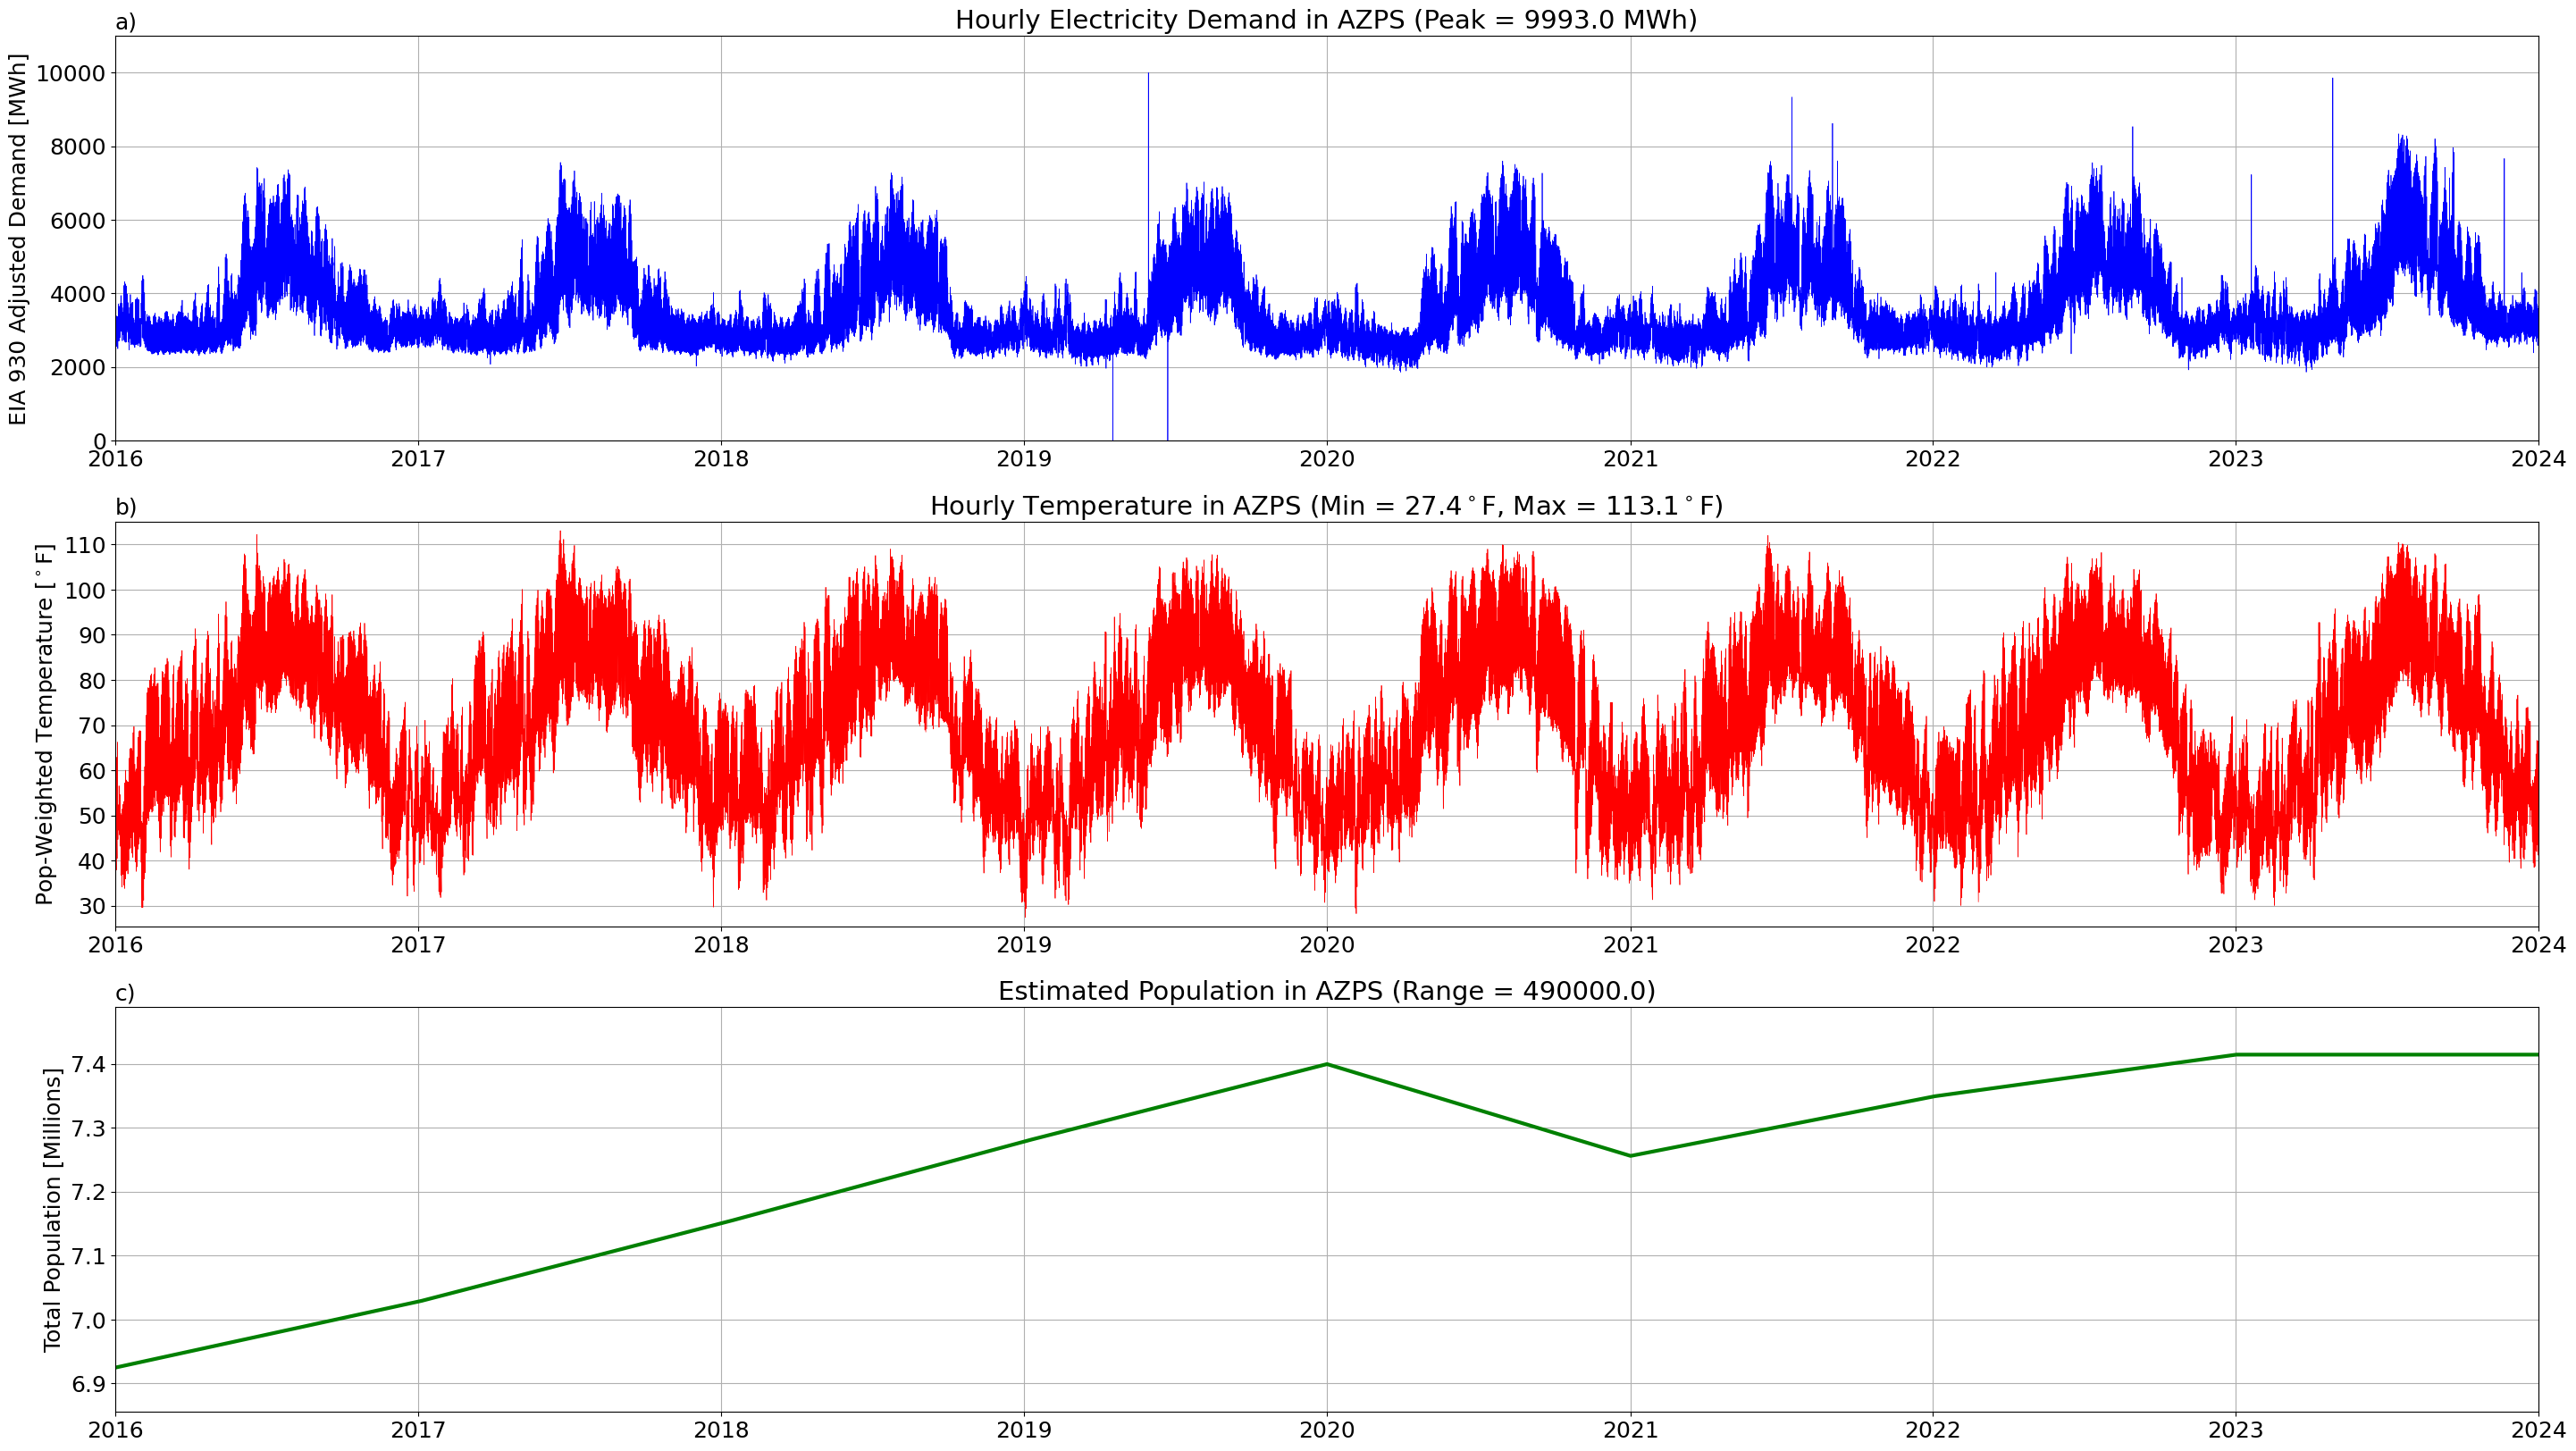

In [4]:
output_df = plot_load_weather_time_series(ba_to_plot = 'AZPS',
                                          start_year = 2016,
                                          end_year = 2023,
                                          ba_data_input_dir = ba_data_input_dir,
                                          image_output_dir = image_output_dir, 
                                          image_resolution = 300, 
                                          save_images = True)

output_df
